<a href="https://colab.research.google.com/github/ManishPalsaniya23/Brain-Tumor-Segmentation/blob/main/Week2/PyTorch_Basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Custom PyTorch Dataset

Modified RandomMRIDataset in order to return a resized  image(128, 128) slice using interpolation

* in MRI Image, bilinear interpolation as it preserves smooth intensity changes

* In Mask, nearest interpolation is used as it avoids fractional class labels

In [4]:
class RandomMRIDataset(Dataset):
    def __init__(self, length=100, out_size =  (128, 128)):
        self.length = length
        self.out_size = out_size

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        image = torch.randn(1, 64, 64)      # fake MRI slice
        mask = (torch.randn(1, 64, 64) > 0).float()  # fake mask

        # Adding batch dims
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        # resize
        image = nn.functional.interpolate(image, size = self.out_size, mode='bilinear', align_corners=False)
        mask = nn.functional.interpolate(mask, size = self.out_size, mode = 'nearest')

        # removing batch dims
        image = image.squeeze(0)
        mask = mask.squeeze(0)

        return image, mask

dataset = RandomMRIDataset()
img, msk = dataset[0]
print(f"Image shape: {img.shape}, Mask shape: {msk.shape}")

Image shape: torch.Size([1, 128, 128]), Mask shape: torch.Size([1, 128, 128])


## DataLoader

In [5]:
loader = DataLoader(dataset, batch_size=8, shuffle=True)

for images, masks in loader:
    print(images.shape, masks.shape)
    break

torch.Size([8, 1, 128, 128]) torch.Size([8, 1, 128, 128])


## Added another convolution layer to SimpleCNN and observed how the model size changes and,

## Training a simple CNN of Random Dataset

In [26]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.classifier(x)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = SimpleCNN().to(device)
print(model)

cuda
SimpleCNN(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=1, bias=True)
    (2): Sigmoid()
  )
)


In [33]:
# Sanity check for input of image (1, 128, 128) as (C,H,W)
x = torch.randn(1, 1, 128, 128).to(device)
y = model(x)

print(y.shape)


torch.Size([1, 1])


## Training Loop Example

In [30]:
model = SimpleCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 5
losses = []
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)

        # convert pixel mask to image-level label (0 or 1)
        labels = (masks.sum(dim=(1,2,3)) > 0).float().unsqueeze(1)
        labels = labels.to(device)

        optimizer.zero_grad()
        preds = model(images)
        loss = loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss/len(loader)
    losses.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

Epoch [1/5], Loss: 0.0709
Epoch [2/5], Loss: 0.0000
Epoch [3/5], Loss: 0.0000
Epoch [4/5], Loss: 0.0000
Epoch [5/5], Loss: 0.0000


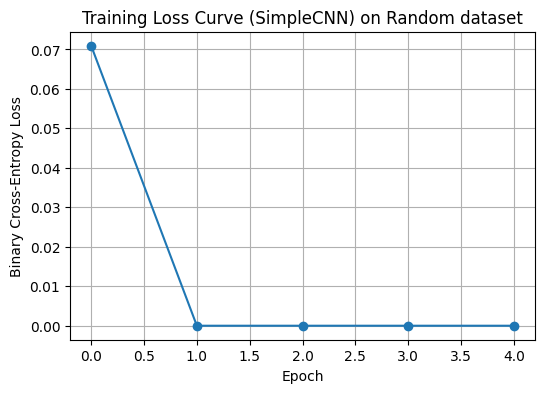

In [31]:
plt.figure(figsize=(6,4))
plt.plot(losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("Training Loss Curve (SimpleCNN) on Random dataset")
plt.grid(True)
plt.show()

## Mini U-Net using conv_block as Building Blocks

In [8]:
def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU()
    )

sample = torch.randn(1, 1, 128, 128)
block = conv_block(1, 16)
output = block(sample)
output.shape

torch.Size([1, 16, 128, 128])

Input (1, 128, 128)
   
Encoder:
  conv_block(1 -> 16)
  MaxPool
  conv_block(16 -> 32)
  MaxPool

Bottleneck:
  conv_block(32 -> 64)

Decoder:
  Upsample
  concat(skip from encoder)
  conv_block(64+32 -> 32)
  Upsample
  concat(skip)
  conv_block(32+16 -> 16)

Output:
  1x1 Conv => Segmentation mask


In [9]:
class MiniUNet(nn.Module):
  def __init__(self, in_channels = 1, out_channels = 1):
    super().__init__()

    # Encoder Block
    self.encoder = nn.Sequential(
        conv_block(in_channels,16),
        nn.MaxPool2d(2),
        conv_block(16,32),
        nn.MaxPool2d(2)
        )

    # Bottleneck
    self.bottleneck = conv_block(32,64)

    # Decoder Block

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64,32,kernel_size = 2, stride = 2),
        conv_block(64,32),
        nn.ConvTranspose2d(32,16,kernel_size =2, stride = 2),
        conv_block(32,16)
    )

    # Output Layer
    self.final = nn.Conv2d(16, out_channels, kernel_size = 1)

  def forward(self, input):
    x = self.encoder(input)
    x = self.bottleneck(x)
    x = self.decoder(x)
    return self.final(x)

In [10]:
model = MiniUNet()
print(model.parameters)

<bound method Module.parameters of MiniUNet(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bottleneck): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): Sequentia

## Custom Dice Loss function for loss computation in Image segmentation

1. Dice Loss function for Binart Segmentation

In [11]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth # to avoid zero division

    def forward(self, preds, targets):
        """
        preds: (N, 1, H, W) -> raw logits or probabilities
        targets: (N, 1, H, W) -> ground truth mask (0 or 1)
        """

        preds = torch.sigmoid(preds)  # convert logits to probabilities

        preds = preds.view(preds.size(0), -1)
        targets = targets.view(targets.size(0), -1)

        intersection = (preds * targets).sum(dim=1)
        dice = (2. * intersection + self.smooth) / \
               (preds.sum(dim=1) + targets.sum(dim=1) + self.smooth)

        return 1 - dice.mean()


2. MultiClass Dice Loss

In [12]:
class MultiClassDiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        """
        preds: (N, C, H, W) logits
        targets: (N, H, W) class labels
        """
        preds = torch.softmax(preds, dim=1)
        targets = torch.nn.functional.one_hot(targets, preds.shape[1])
        targets = targets.permute(0, 3, 1, 2).float()

        preds = preds.contiguous().view(preds.size(0), preds.size(1), -1)
        targets = targets.contiguous().view(targets.size(0), targets.size(1), -1)

        intersection = (preds * targets).sum(dim=2)
        dice = (2 * intersection + self.smooth) / \
               (preds.sum(dim=2) + targets.sum(dim=2) + self.smooth)

        return 1 - dice.mean()
